In [1]:
import tensorflow as tf

from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
import cv2
import random

In [2]:
def convertImg(image, size=(32,32)):
    image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    converted = np.zeros(shape=(size[0], size[1], 1))
    for y in range(0, len(image)):
        for x in range(0, len(image[y])):
            converted[y][x][0] = image[y][x]

    converted = converted/255
    return converted

In [3]:
# trainImages / Images
ratio = 0.8
train_data = []
test_data = []

class_names = os.listdir('./trainData')
print(class_names)

for class_name in class_names:
    data = os.listdir('./trainData/{class_name}'.format(class_name=class_name))
    for i in range(0, len(data)):
        image = convertImg(utils.loadImage(path='./trainData/{class_name}'.format(class_name=class_name), name=data[i], resize=(32,32)))
        if(i/len(data) < ratio):
            train_data.append((image,class_names.index(class_name)))
        else:
            test_data.append((image,class_names.index(class_name)))

random.shuffle(train_data)
random.shuffle(test_data)

train_images = []
train_labels = []
test_images = []
test_labels = []

for data in train_data:
    train_images.append(data[0])
    train_labels.append([data[1]])

for data in test_data:
    test_images.append(data[0])
    test_labels.append([data[1]])

train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

['capacitor', 'ground', 'inductor', 'resistor']


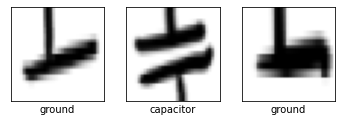

In [4]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(class_names)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              

#history = model.fit(train_images, train_labels, epochs=10, 
#                    validation_data=(test_images, test_labels))

history = model.fit(train_images, train_labels, epochs=150, 
                    validation_data=(train_images, train_labels))


Epoch 1/150
2/2 [==============================] - 1s 285ms/step - loss: 1.4026 - accuracy: 0.0606 - val_loss: 1.3008 - val_accuracy: 0.3333
Epoch 2/150
2/2 [==============================] - 0s 30ms/step - loss: 1.3012 - accuracy: 0.3333 - val_loss: 1.2234 - val_accuracy: 0.3333
Epoch 3/150
2/2 [==============================] - 0s 33ms/step - loss: 1.2187 - accuracy: 0.3636 - val_loss: 1.1447 - val_accuracy: 0.6667
Epoch 4/150
2/2 [==============================] - 0s 51ms/step - loss: 1.1454 - accuracy: 0.6667 - val_loss: 1.1319 - val_accuracy: 0.5455
Epoch 5/150
2/2 [==============================] - 0s 41ms/step - loss: 1.1304 - accuracy: 0.5455 - val_loss: 1.1099 - val_accuracy: 0.5758
Epoch 6/150
2/2 [==============================] - 0s 40ms/step - loss: 1.1091 - accuracy: 0.5758 - val_loss: 1.0246 - val_accuracy: 0.6970
Epoch 7/150
2/2 [==============================] - 0s 44ms/step - loss: 1.0193 - accuracy: 0.6970 - val_loss: 0.8976 - val_accuracy: 0.6364
Epoch 8/150
2/2 [==

In [7]:
model.save('saved_model/my_model')
model.save('../src/saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets
INFO:tensorflow:Assets written to: ../src/saved_model/my_model\assets


In [8]:
#boxes = [[[100,100],[120,120]],[[140,100],[180,120]]]
#image = utils.loadImage("../src/testImages", "1.png")

def classify(boxes, image):
    
    model = tf.keras.models.load_model('saved_model/my_model')

    components = []
    for box in boxes:
        component = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        components.append(convertImg(component).reshape(-1,32,32,1))

    modelPredictions = model.predict(np.vstack(components))

    predictions = []

    for prediction in modelPredictions:
        predictions.append(class_names[np.argmax(prediction)])

    return predictions


In [9]:
#new_model = tf.keras.models.load_model('saved_model/my_model')
#
## Check its architecture
##new_model.summary()
#
#img = convertImg(utils.loadImage(path='./../dev/trainData/inductor/', name='20.png', resize=(32,32)))
#
##img = train_images[3]
#
#
#predictions_single = model.predict(img.reshape(-1,32,32,1))[0]
#print(class_names)
#print(predictions_single)
#print(class_names[np.where(predictions_single == np.amax(predictions_single))[0][0]])
#
#plt.imshow(img, cmap='gray')

2/2 - 0s - loss: 6.2122e-05 - accuracy: 1.0000
1.0


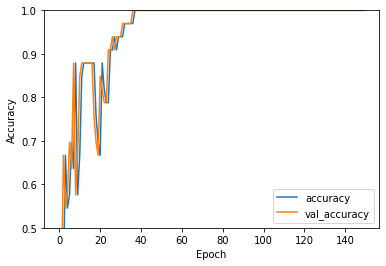

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
test_loss, test_acc = model.evaluate(train_images,  train_labels, verbose=2)

print(test_acc)